## 层和块
层**接受一组输入，生成相应的输出，由一组可调整参数描述**

块(block)“比单个层大”但“比整个模型小”的组件

从编程的角度来看，块由类（class）表示。 它的任何子类都必须定义一个**将其输入转换为输出**的**前向传播函数**， 并且必须**存储任何必需的参数**。 注意，有些块不需要任何参数。 最后，为了**计算梯度**，块必须具有**反向传播函数**。

本项目中的Layer基类实现了
1. 正向传播虚函数
2. 记录模型所有的参数和层
3. 按结构展平参数
4. 将展平后的参数储存npz文件中
5. 从npz文件中读取参数

In [ ]:
class Layer:
    def __init__(self):
        self._params: set[str] = set() # 记录模型所有参数和层

    def __setattr__(self, key, value):
        if isinstance(value, (Parameter, Layer)): # 检查value是否是Parameter或Layer类
            self._params.add(key)
        super(Layer, self).__setattr__(key, value) # 同时
    # obj.attr = ...时调用该函数

    def __call__(self, *inputs: Union[Variable, np.ndarray]) -> Union[list[Variable], Variable]:
        outputs = self.forward(*inputs)
        if not isinstance(outputs, tuple):
            outputs = (outputs,)
        self.inputs = [weakref.ref(x) for x in inputs]
        self.outputs = [weakref.ref(y) for y in outputs]
        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, *inputs):
        raise NotImplementedError()

    def params(self):
        for name in self._params:
            obj = self.__dict__[name] # 获取属性名为name的属性的值
            if isinstance(obj, Layer):
                yield from obj.params() # 生成
            else:
                yield obj

    def cleargrads(self):
        for param in self.params():
            param.cleargrad()

    def to_cpu(self):
        for param in self.params():
            param.to_cpu()

    def to_gpu(self):
        for param in self.params():
            param.to_gpu()

    def _flatten_params(self, params_dict, parent_key=""): # 将模型参数展开到一个字典
        for name in self._params:
            obj = self.__dict__[name]
            key = parent_key + '/' + name if parent_key else name

            if isinstance(obj, Layer):
                obj._flatten_params(params_dict, key)
            else:
                params_dict[key] = obj # 储存的应该是Parameter对象

    def save_weights(self, path):
        self.to_cpu()
        params_dict = {}
        self._flatten_params(params_dict)
        array_dict = {key: param.data for key, param in params_dict.items()
                      if param is not None}
        try:
            np.savez_compressed(path, **array_dict) # **用于解包字典
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(path):
                os.remove(path)
            raise

    def load_weights(self, path):
        npz = np.load(path)
        params_dict = {}
        self._flatten_params(params_dict)
        for key, param in params_dict.items():
            param.data = npz[key]
            print(f'{key} loaded')

In [ ]:
# Linear子类
class Linear(Layer):
    def __init__(self, out_size: int, nobias: bool = False, dtype=np.float32, in_size: int = None):
        super(Linear, self).__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.dtype = dtype

        self.W = Parameter(None, name='W')
        if self.in_size is not None:
            self._init_W()

        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(out_size, dtype=dtype), name='b')

    def _init_W(self):
        I, O = self.in_size, self.out_size
        W_data = np.random.randn(I, O).astype(self.dtype) * np.sqrt(1 / I) # Xavier初始化的一种形式
        self.W = Parameter(W_data, name='W')

    def forward(self, x):
        if self.W.data is None:
            self.in_size = x.shape[1]
            self._init_W()
        y = linear(x, self.W, self.b) # Function对象
        return y


### Xavier参数初始化方法

[Xavier 初始化【简单易懂】](https://zhuanlan.zhihu.com/p/653754525)

#### 1. 作用
1. 解决梯度消失和爆炸：在深度网络中，梯度消失和梯度爆炸是一个常见的问题。如果每一层都将方差放大，那么在多层网络中，梯度可能会**很快增长至非常大的值（爆炸），或者减小至接近零（消失）**。Xavier 初始化试图使得**每一层的输出的方差接近于其输入的方差**，从而避免梯度消失或梯度爆炸的问题。
2. 加速收敛：Xavier 初始化使得每一层的输出的方差接近于其输入的方差，从而使得每一层的**梯度的方差接近于 1**。这样，每一层的参数更新的幅度就不会相差太大，从而加速收敛。
3. 使权重分布均匀: 初始权重要尽可能接近均匀分布，以避免神经元的激活输出在前向传播过程中过早饱和或消失。

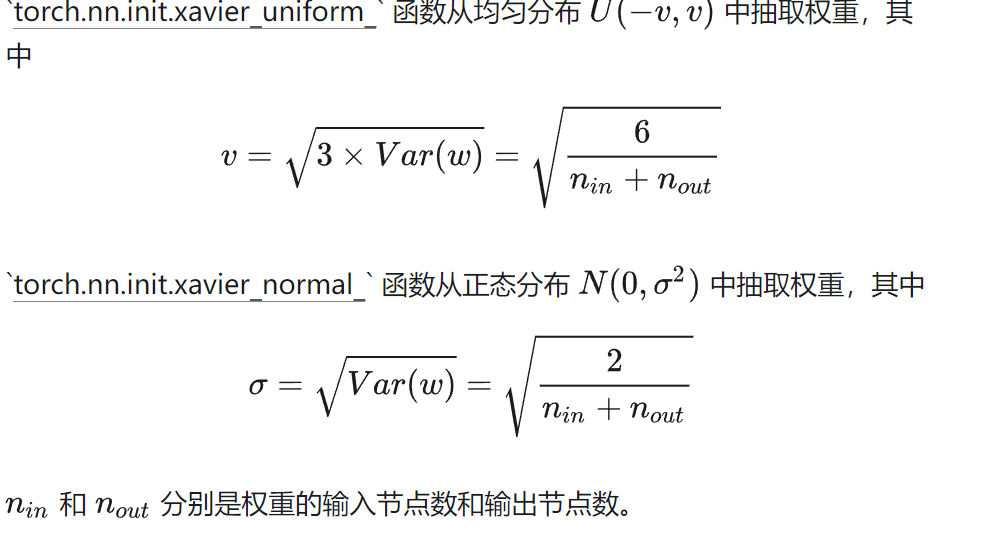